In [1]:
import netCDF4 as nc
import numpy as np
import iris.coords as coords
import cf_units
import iris.cube as icube
import pdb
from scipy.stats import kurtosis
from scipy import stats
import seaborn as sns
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import math
import numpy.ma as ma
import datetime as dt
import iris.plot as iplt
import matplotlib as mpl
import iris
# import functions
from FidelityTest import calcDistrStatistic, timeseries_fid_test, plot_fidelity_testing, get_cube_limits, plotStatsMeasures
from BiasCorrection import mean_bias_correction, kurtosis_power_transform, ratio_correction,Quantile_mapping,ks_compare_distributions,mean_correction, calculate_return_periods,plot_return_periods

In [2]:
# load model data
file_path = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_pr_model_DePreSys4.nc'  
model4 = nc.Dataset(file_path, mode='r')

pr_model4 = model4.variables['unknown'][:]
pr_model4.shape
#model4.variables.keys()

(10, 30, 10)

In [3]:
# load model data
file_path = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_pr_model_DePreSys3.nc'  
model3 = nc.Dataset(file_path, mode='r')

pr_model3 = model3.variables['unknown'][:]
pr_model3.shape
model3.variables.keys()

dict_keys(['unknown', 'latitude_longitude', 'dim0', 'time', 'time_bnds', 'realization', 'latitude', 'latitude_bnds', 'longitude', 'longitude_bnds', 'month', 'month_number', 'month_number_bnds', 'season_year', 'season_year_bnds', 'year'])

In [4]:
# load obs data
file_path = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_pr_obs_ERA5-Land.nc'  
summer_pr_obs = nc.Dataset(file_path, mode='r')
summer_pr_obs.variables.keys()
pr_obs = summer_pr_obs.variables['tp'][:]
pr_obs.shape

(30,)

In [5]:
variable_name = 'year' 
var = model3.variables[variable_name]
print(f"Variable: {variable_name}")
print(f"Shape: {var.shape}") 
print(f"Dimensions: {var.dimensions}") 
for i in range(var.shape[0]):  
    print(f"Time index {i}: {var[i]}")

Variable: year
Shape: (30,)
Dimensions: ('time',)
Time index 0: 1992
Time index 1: 1993
Time index 2: 1994
Time index 3: 1995
Time index 4: 1996
Time index 5: 1997
Time index 6: 1998
Time index 7: 1999
Time index 8: 2000
Time index 9: 2001
Time index 10: 2002
Time index 11: 2003
Time index 12: 2004
Time index 13: 2005
Time index 14: 2006
Time index 15: 2007
Time index 16: 2008
Time index 17: 2009
Time index 18: 2010
Time index 19: 2011
Time index 20: 2012
Time index 21: 2013
Time index 22: 2014
Time index 23: 2015
Time index 24: 2016
Time index 25: 2017
Time index 26: 2018
Time index 27: 2019
Time index 28: 2020
Time index 29: 2021


In [6]:
# reshape simulations from 3 dimensions to 2 dimensions
def reshape_model(simulations):  
    # reshape model simulations
    n_ensembles = simulations.shape[1]  
    n_months = simulations.shape[2]  
    model = simulations[:].reshape(n_ensembles, -1)
    return model

In [7]:
# new reshape simulations from 3 dimensions to 2 dimensions
def new_reshape_model(simulations):  
    # reshape model simulations
    n_years = simulations.shape[1]  
    n_months = simulations.shape[2]  
    new_model = np.transpose(simulations[:], (1, 0, 2))
    new_model = new_model.reshape(n_years, -1)
    return new_model

In [13]:
print(pr_model3.shape)
print(pr_model4.shape)

model3 = reshape_model(pr_model3)
model4 = reshape_model(pr_model4)
model3

new_model3 = new_reshape_model(pr_model3)
new_model4 = new_reshape_model(pr_model4)

(2, 30, 40)
(10, 30, 10)


In [9]:
# create cube for plotting
def convert_array_cube(data):
    time_coord = coords.DimCoord(range(data.shape[0]), standard_name='time')
    if data.ndim > 1:
        year_coord = coords.DimCoord(range(data.shape[1]), standard_name='realization')
        # define units for each coord
        year_coord.units = cf_units.Unit('years since 1992', calendar='gregorian')
        cube = iris.cube.Cube(data, dim_coords_and_dims=[(time_coord, 0), (year_coord, 1)])
    else:
        cube = iris.cube.Cube(data, dim_coords_and_dims=[(time_coord, 0)])
    cube.long_name = 'Hunan_Summer_data'
    cube.units = 'celsius'
    return cube

In [10]:
mod3 = convert_array_cube(model3)
mod4 = convert_array_cube(model4)
obs = convert_array_cube(pr_obs)
obs.shape

new_mod3 = convert_array_cube(new_model3)
new_mod4 = convert_array_cube(new_model4)

In [11]:
def plotting_obs_mod(obs,mod):
    obs_data = obs.data
    mod_data = mod.data
    years = np.arange(1992, 2022)
    mod_mean = mod_data.mean(axis=1)
    mod_std = mod_data.std(axis=1)

    plt.figure(figsize=(15, 8))
    plt.plot(years, obs_data, label='Observations', color='black', linewidth=2, linestyle='--')
    for i in range(mod_data.shape[1]):
        plt.plot(years, mod_data[:, i], color='grey', alpha=0.2)
    plt.plot(years, mod_mean, label='DePreSys4_mean', color='red', linewidth=2, linestyle='--')
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Precipitation')
    #plt.title('Hunan Summer Precipitation Averaged 1993-2022')
    plt.show()

Hunan Summer Precipitation for DePreSys3 Data:


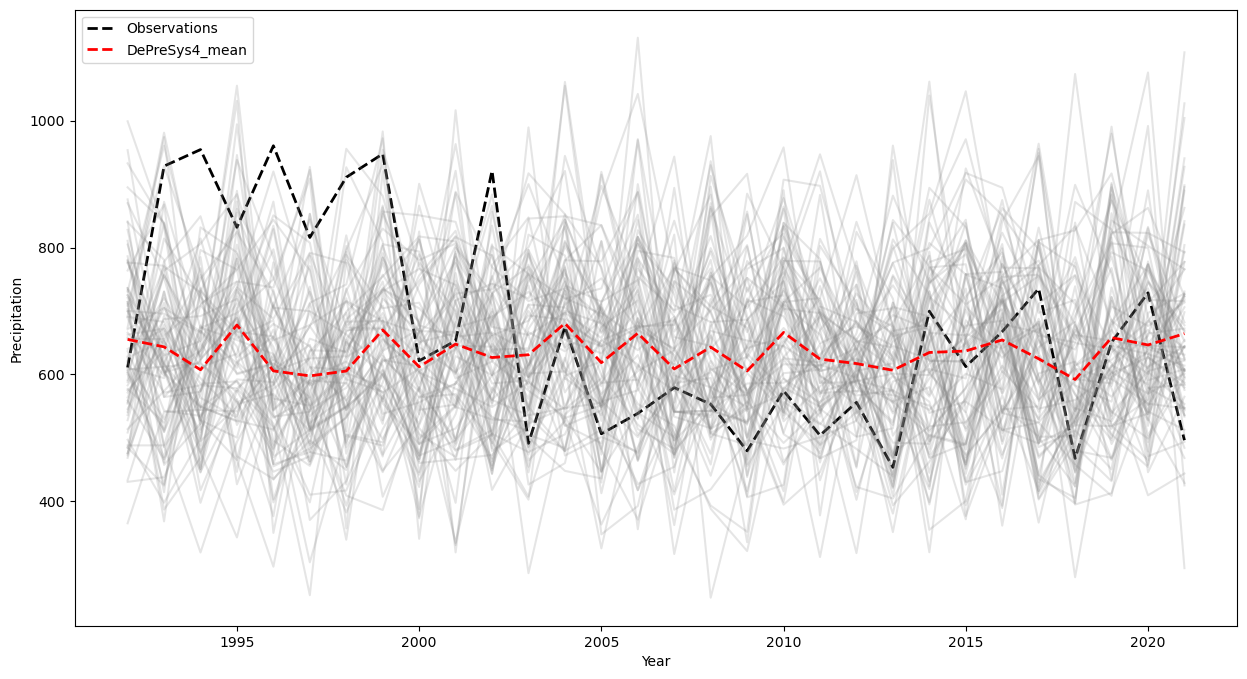

Hunan Summer Precipitation for DePreSys4 Data:


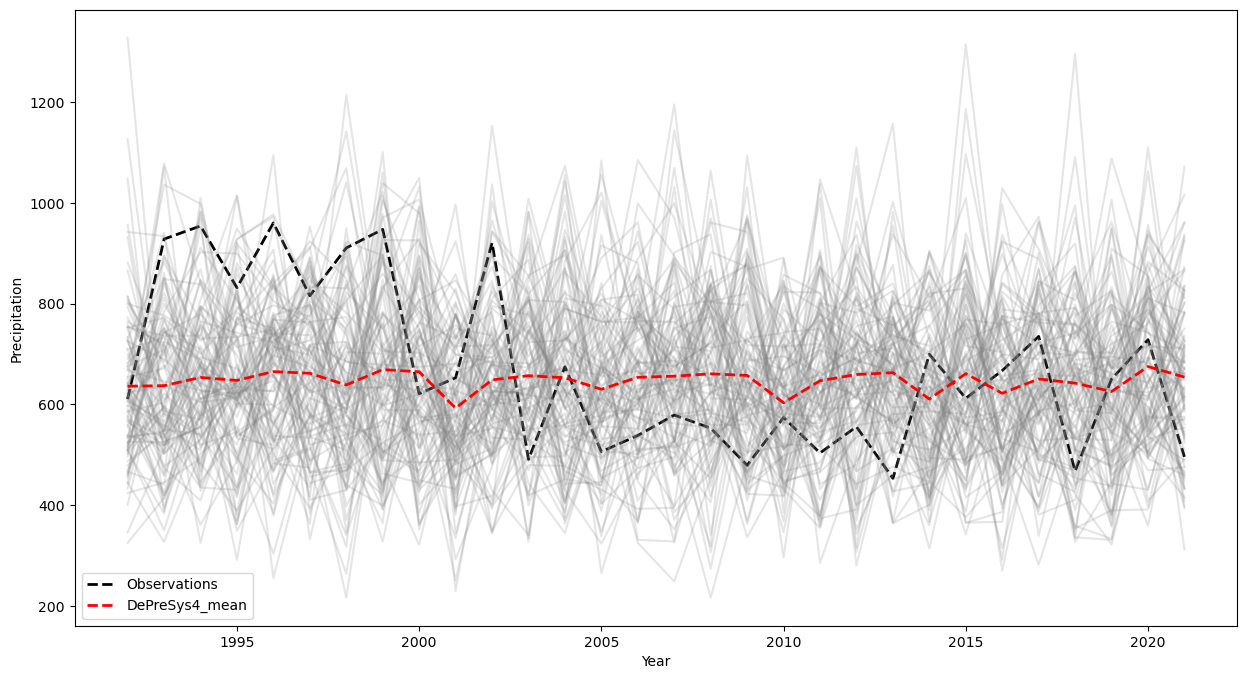

Hunan Summer Precipitation for DePreSys3 Data:


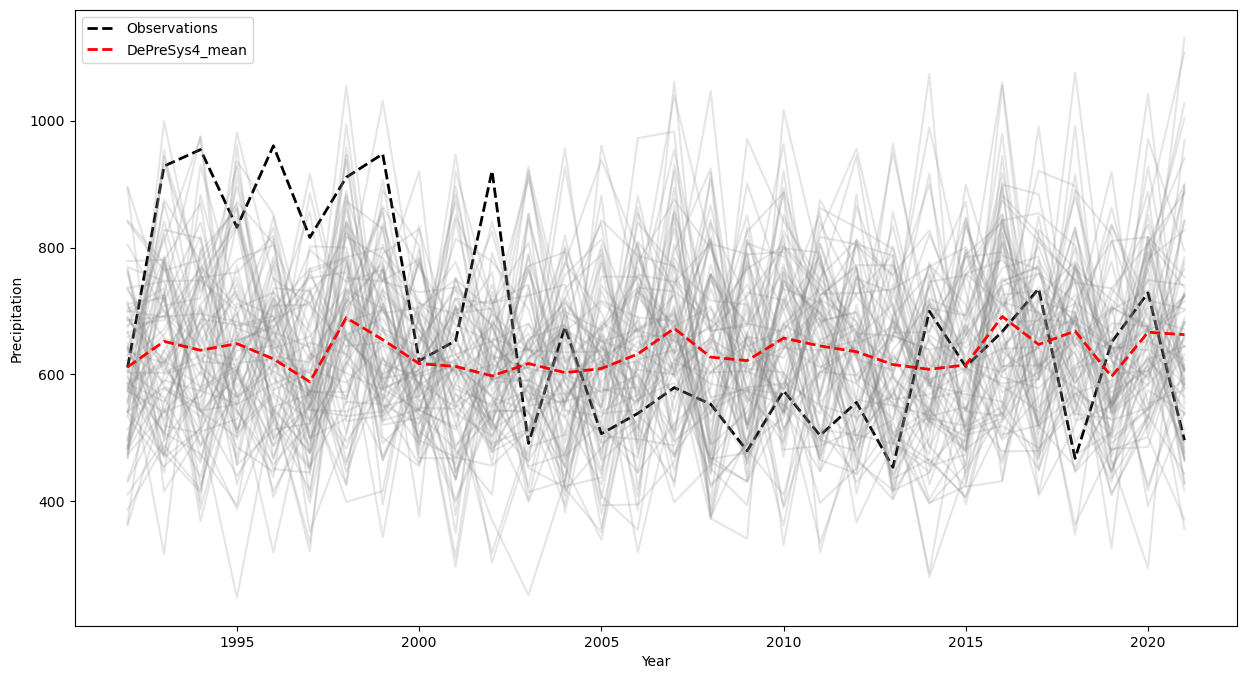

Hunan Summer Precipitation for DePreSys4 Data:


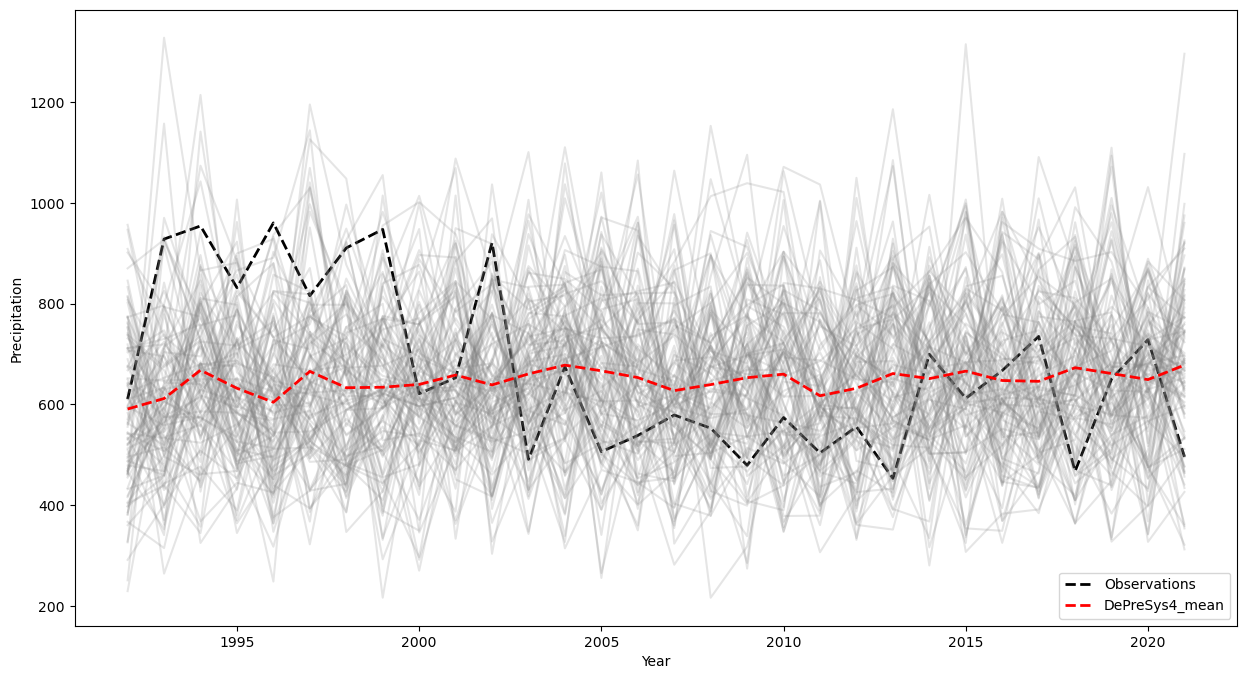

In [12]:
print("Hunan Summer Precipitation for DePreSys3 Data:")
plotting_obs_mod(obs, mod3)
print("Hunan Summer Precipitation for DePreSys4 Data:")
plotting_obs_mod(obs, mod4)

print("Hunan Summer Precipitation for DePreSys3 Data:")
plotting_obs_mod(obs, new_mod3)
print("Hunan Summer Precipitation for DePreSys4 Data:")
plotting_obs_mod(obs, new_mod4)

In [23]:
def plotting_obs_mod(obs, mod, mod_corrected):
    obs_data = obs.data
    mod_data = mod.data
    mod_corrected_data = mod_corrected
    years = np.arange(1992, 2022)
    mod_mean = mod_data.mean(axis=1)
    mod_std = mod_data.std(axis=1)
    
    mod_corrected_mean = mod_corrected_data.mean(axis=1)
    mod_corrected_std = mod_corrected_data.std(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].plot(years, obs_data, label='Observations', color='black', linewidth=2, linestyle='--')
    for i in range(mod_data.shape[1]):
        axes[0].plot(years, mod_data[:, i], color='grey', alpha=0.2)
    axes[0].plot(years, mod_mean, label='DePreSys3_mean', color='red', linewidth=2, linestyle='--')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Precipitation')
    axes[0].set_title('Original Model')
    axes[0].legend()
    axes[1].plot(years, obs_data, label='Observations', color='black', linewidth=2, linestyle='--')
    for i in range(mod_corrected_data.shape[1]):
        axes[1].plot(years, mod_corrected_data[:, i], color='grey', alpha=0.2)
    axes[1].plot(years, mod_corrected_mean, label='DePreSys3_corrected_mean', color='blue', linewidth=2, linestyle='--')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Precipitation')
    axes[1].set_title('Corrected Model')
    axes[1].legend()
    plt.tight_layout()
    plt.show()


Hunan Summer Precipitation for DePreSys4 Data:


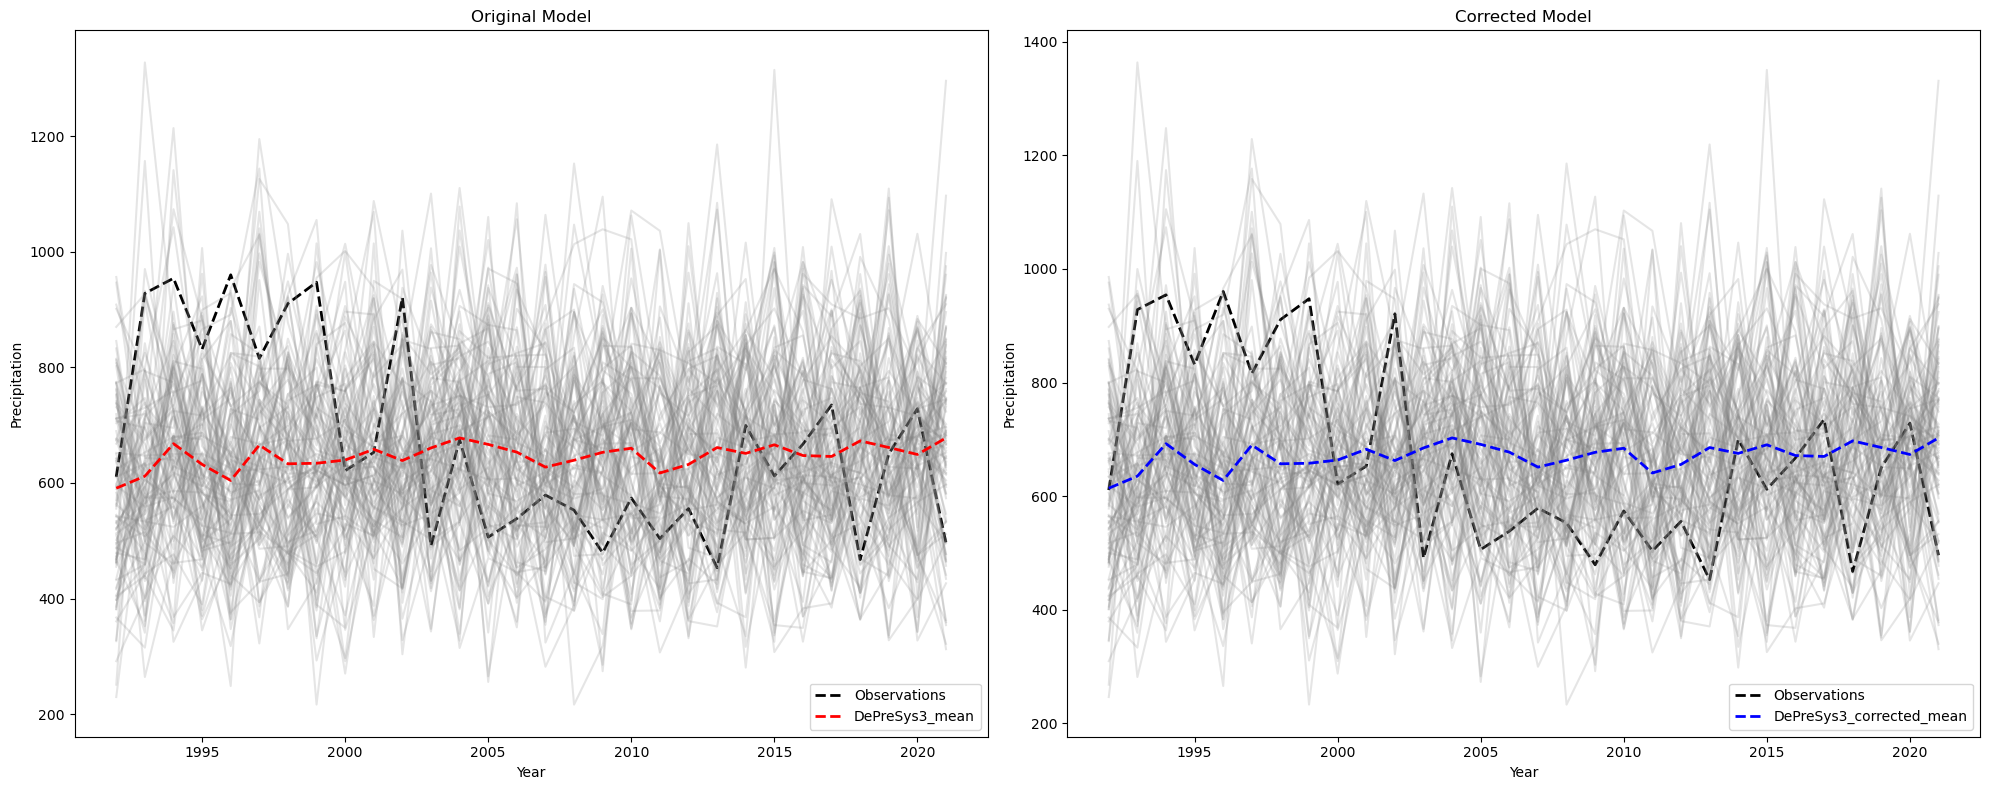

In [27]:
print("Hunan Summer Precipitation for DePreSys4 Data:")
plotting_obs_mod(obs, new_mod4, new_model4_ratiocor)

## Fidelity Test

In [14]:
print("(1) result of fidelity testing for DePreSys3 data:\n")
stats_measures3=timeseries_fid_test(obs.data,mod3.data)
print("\n(2) result of fidelity testing for DePreSys4 data:\n")
stats_measures4=timeseries_fid_test(obs.data,mod4.data)

print("(1) result of fidelity testing for DePreSys3 data:\n")
new_stats_measures3=timeseries_fid_test(obs.data,new_mod3.data)
print("\n(2) result of fidelity testing for DePreSys4 data:\n")
new_stats_measures4=timeseries_fid_test(obs.data,new_mod4.data)

(1) result of fidelity testing for DePreSys3 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 95.64
Standard deviation perc: 97.66
Skewness perc: 79.12
Kurtosis perc: 5.58
Linear trend perc: 0.0

(2) result of fidelity testing for DePreSys4 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 73.04
Standard deviation perc: 58.41
Skewness perc: 73.9
Kurtosis perc: 5.24
Linear trend perc: 0.09
(1) result of fidelity testing for DePreSys3 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 96.09
Standard deviation perc: 97.77
Skewness perc: 78.07
Kurtosis perc: 4.43
Linear trend perc: 0.0

(2) result of fidelity testing for DePreSys4 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 92.17
Standard deviation perc: 63.72
Skewness perc: 68.36
Kurtosis perc: 3.2300000000000004
Linear trend perc: 0.02


plotting


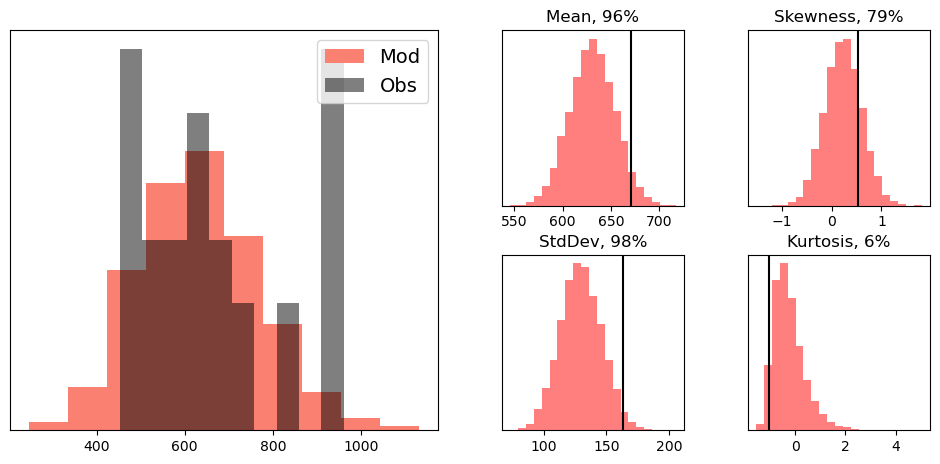

plotting


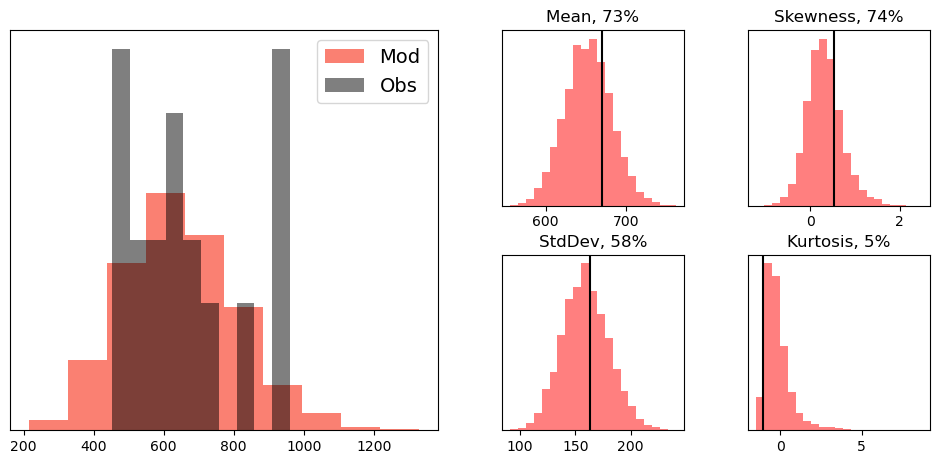

plotting


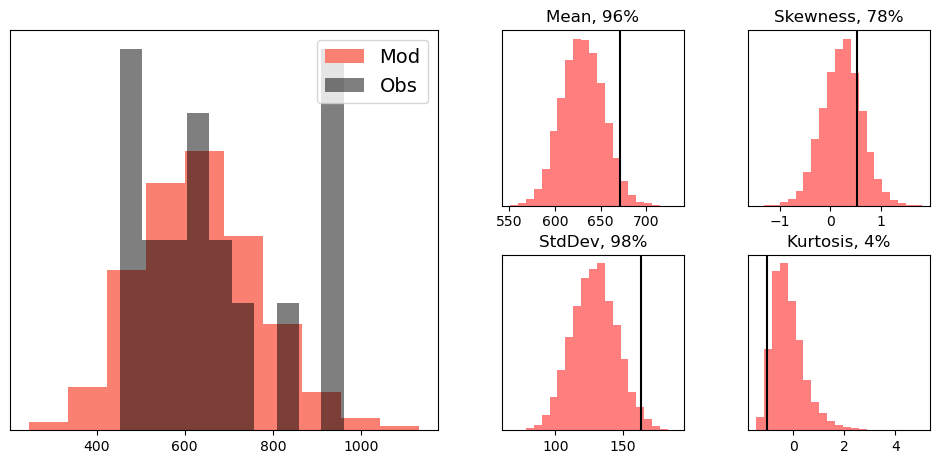

plotting


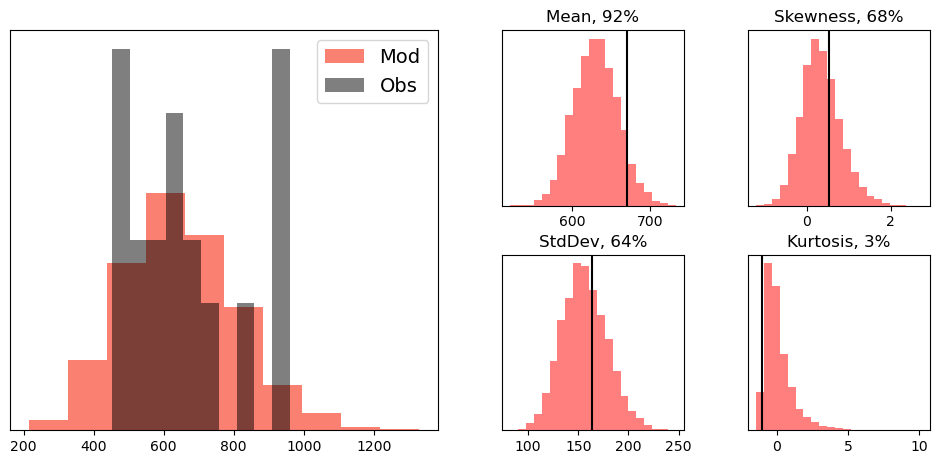

In [15]:
plot_fidelity_testing(obs.data, mod3.data, stats_measures3, 0.1,"fidelity test for DePreSys3 Precipitation data","1.png")
plot_fidelity_testing(obs.data, mod4.data, stats_measures4, 0.1,"fidelity test for DePreSys4 Precipitation data","2.png")

plot_fidelity_testing(obs.data, new_mod3.data, new_stats_measures3, 0.1,"fidelity test for DePreSys3 Precipitation data","1.png")
plot_fidelity_testing(obs.data, new_mod4.data, new_stats_measures4, 0.1,"fidelity test for DePreSys4 Precipitation data","2.png")

## Bias Correction

### 1) DePreSys3 Data : 

In [33]:
model3_meancor= mean_bias_correction(obs.data, model3)
new_model3_meancor= mean_bias_correction(obs.data, new_model3)

In [ ]:
stats_measures_cor3=timeseries_fid_test(obs.data,model3_meancor)
plot_fidelity_testing(obs.data, model3_meancor, stats_measures_cor3, 0.1,"Bias Correction for DePreSys3 Precipitation data  ","1.png")

### 2) DePreSys4 Data Bias Correction:

In [21]:
model4_meancor= mean_bias_correction(obs.data, mod4.data)
#model4_kurtcor = kurtosis_power_transform(mod4.data)

new_model4_meancor= mean_bias_correction(obs.data, new_mod4.data)


model4_ratiocor= ratio_correction(obs.data, mod4.data)
new_model4_ratiocor= ratio_correction(obs.data, new_mod4.data)


Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 42.55
Standard deviation perc: 59.85
Skewness perc: 73.83
Kurtosis perc: 5.12
Linear trend perc: 0.03
plotting


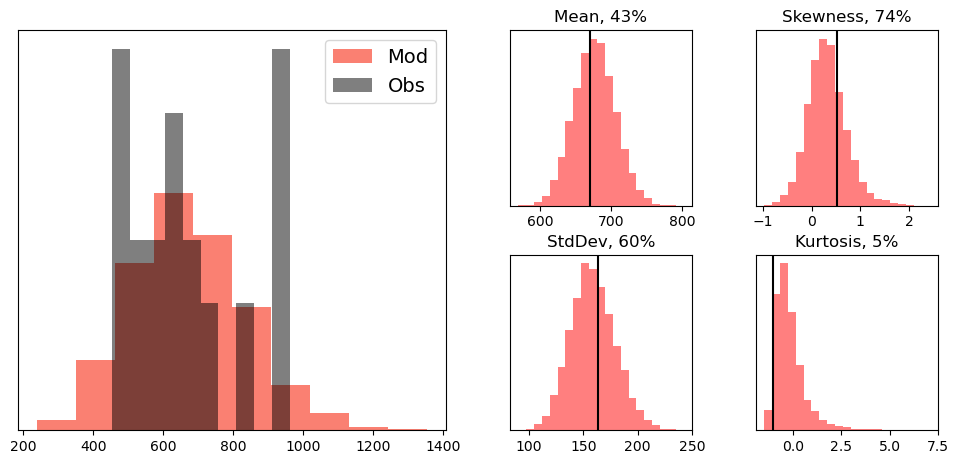

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 71.32
Standard deviation perc: 63.61
Skewness perc: 68.28
Kurtosis perc: 3.5000000000000004
Linear trend perc: 0.04
plotting


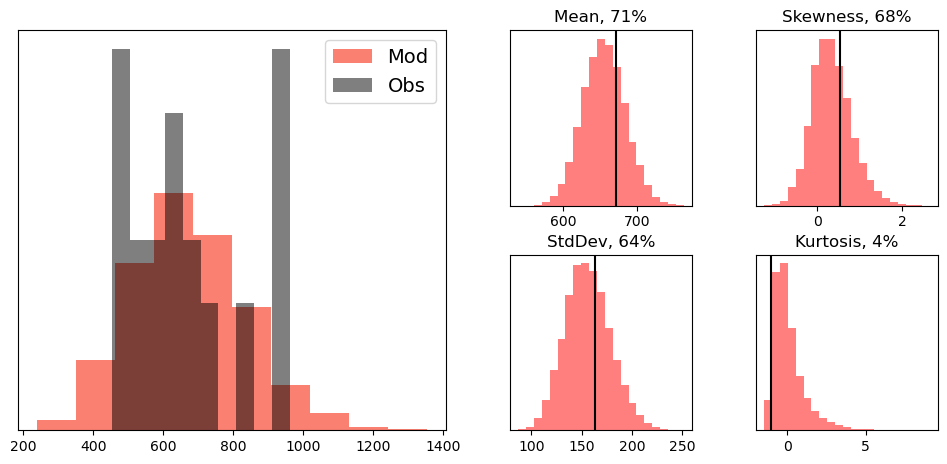

In [19]:
stats_measures_cor4=timeseries_fid_test(obs.data,model4_meancor)
plot_fidelity_testing(obs.data, model4_meancor, stats_measures_cor4, 0.1,"Bias Correction for DePreSys4 data","1.png")
                     
new_stats_measures_cor4=timeseries_fid_test(obs.data,new_model4_meancor)
plot_fidelity_testing(obs.data, new_model4_meancor, new_stats_measures_cor4, 0.1,"Bias Correction for DePreSys4 data","1.png")

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 71.00999999999999
Standard deviation perc: 59.040000000000006
Skewness perc: 68.44
Kurtosis perc: 3.73
Linear trend perc: 0.02
plotting


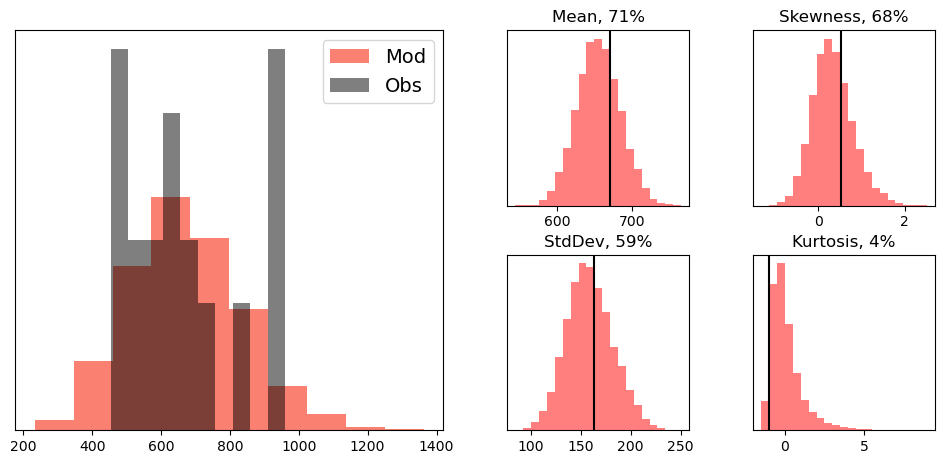

In [22]:
new_stats_measures_cor4=timeseries_fid_test(obs.data,new_model4_ratiocor)
plot_fidelity_testing(obs.data, new_model4_ratiocor, new_stats_measures_cor4, 0.1,"Bias Correction for DePreSys4 data","1.png")

In [28]:
def ks_compare_distributions(obs, mod, mod_cor, n_series=10000):
    def generate_random_series(mod, n_series):
        m, n = mod.shape
        random_series = np.zeros((n_series, m))
        for i in range(n_series):
            random_columns = np.random.randint(0, n, m)
            random_series[i] = mod[np.arange(m), random_columns]
        return random_series

    def perform_ks_tests(obs, random_series):
        ks_statistics = []
        p_values = []
        for series in random_series:
            ks_statistic, p_value = stats.ks_2samp(obs, series)
            ks_statistics.append(ks_statistic)
            p_values.append(p_value)
        return np.array(ks_statistics), np.array(p_values)

    def plot_results(statistics_mod, p_values_mod, statistics_mod_cor, p_values_mod_cor):
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        #fig.suptitle("KS test result: comparison of mod and mod_cor with obs", fontsize=25)
        plt.rc('axes', titlesize=20)
        plt.rc('axes', labelsize=20)
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        plt.rc('legend', fontsize=18)

        # K-S Statistics Distribution
        sns.histplot(statistics_mod, kde=True, ax=axes[0], color='blue', alpha=0.5, label='mod')
        sns.histplot(statistics_mod_cor, kde=True, ax=axes[0], color='red', alpha=0.5, label='mod_cor')
        axes[0].set_title('Distribution of K-S Statistics')
        axes[0].set_xlabel('K-S Statistic')
        axes[0].legend()

        # p-values Distribution
        sns.histplot(p_values_mod, kde=True, ax=axes[1], color='blue', alpha=0.5, label='mod')
        sns.histplot(p_values_mod_cor, kde=True, ax=axes[1], color='red', alpha=0.5, label='mod_cor')
        axes[1].set_title('Distribution of p-values')
        axes[1].set_xlabel('p-value')
        axes[1].legend()
        plt.tight_layout()
        plt.show()

    def print_summary(statistics, p_values, name):
        print(f"Summary for {name}:")
        print(f"Mean K-S Statistic: {np.mean(statistics):.4f}")
        print(f"Mean p-value: {np.mean(p_values):.4f}")
        print(f"Proportion of significant results (p < 0.05): {np.mean(p_values < 0.05):.2%}")

    # Process mod
    random_series_mod = generate_random_series(mod, n_series)
    statistics_mod, p_values_mod = perform_ks_tests(obs, random_series_mod)

    # Process mod_cor
    random_series_mod_cor = generate_random_series(mod_cor, n_series)
    statistics_mod_cor, p_values_mod_cor = perform_ks_tests(obs, random_series_mod_cor)

    # Plot results
    plot_results(statistics_mod, p_values_mod, statistics_mod_cor, p_values_mod_cor)

    # Print summaries
    print_summary(statistics_mod, p_values_mod, "mod")
    print("\n")
    print_summary(statistics_mod_cor, p_values_mod_cor, "mod_cor")

## K-S Test

In [ ]:
ks_compare_distributions(obs.data, mod3.data,model3_meancor)

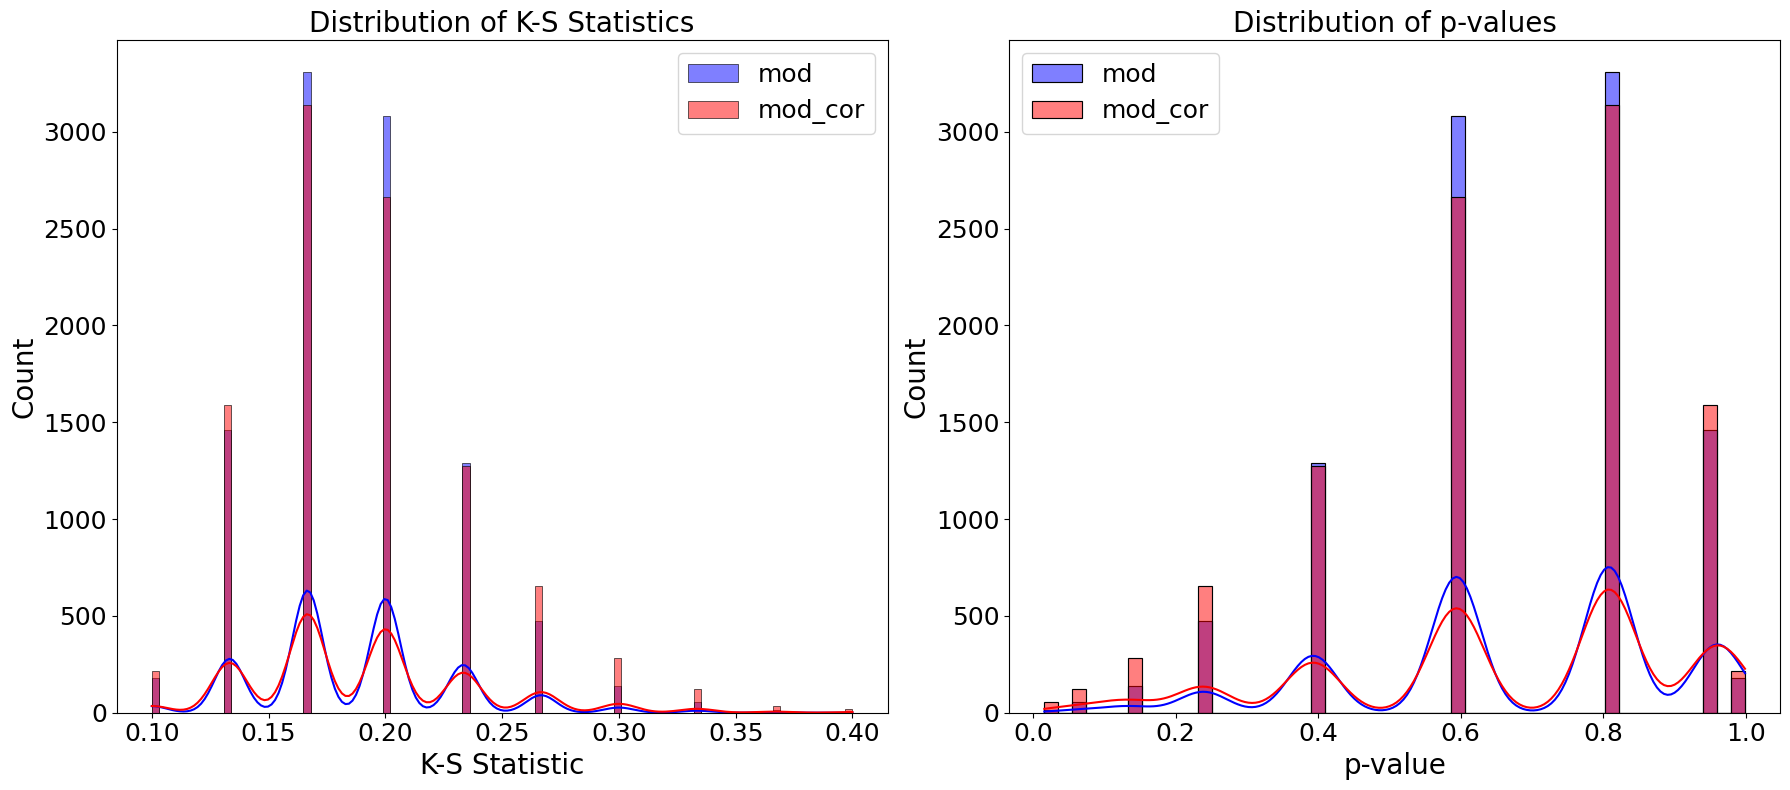

Summary for mod:
Mean K-S Statistic: 0.1873
Mean p-value: 0.6723
Proportion of significant results (p < 0.05): 0.14%


Summary for mod_cor:
Mean K-S Statistic: 0.1909
Mean p-value: 0.6560
Proportion of significant results (p < 0.05): 0.56%


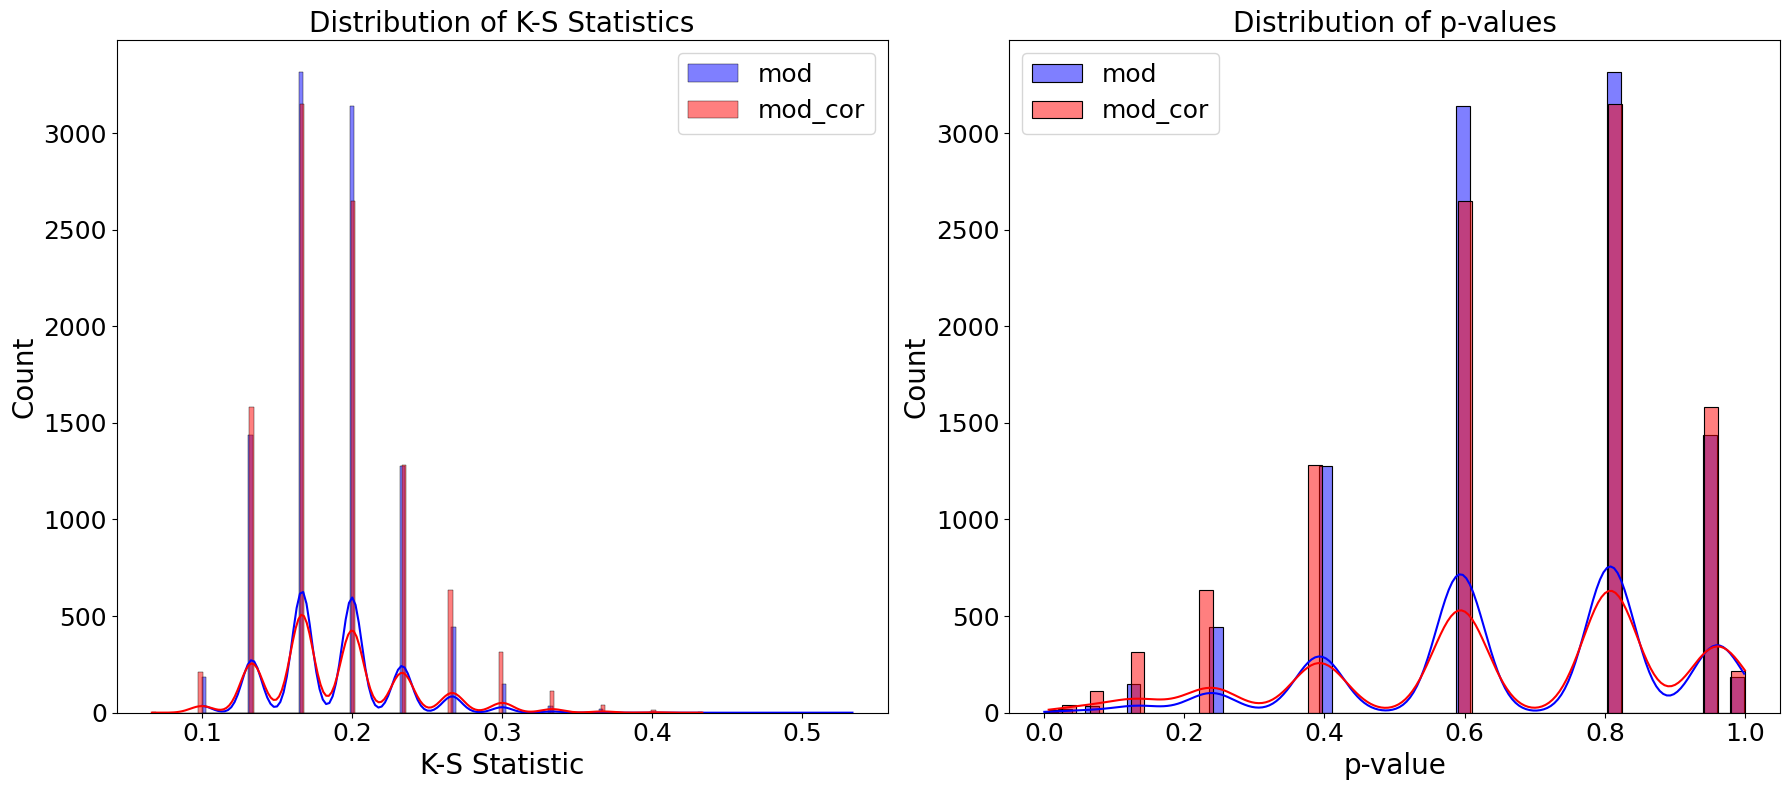

Summary for mod:
Mean K-S Statistic: 0.1871
Mean p-value: 0.6732
Proportion of significant results (p < 0.05): 0.23%


Summary for mod_cor:
Mean K-S Statistic: 0.1910
Mean p-value: 0.6557
Proportion of significant results (p < 0.05): 0.57%


In [30]:
ks_compare_distributions(obs.data, mod4.data,model4_meancor)

ks_compare_distributions(obs.data, new_mod4.data,new_model4_meancor)

In [ ]:
def ensemble_bootstrap(mod_data, n_samples=10000):
    years, ensembles = mod_data.shape
    all_samples = np.zeros((years, n_samples))
    for i in range(n_samples):
        for year in range(years):
            ensemble = np.random.choice(ensembles)
            all_samples[year, i] = mod_data[year, ensemble]

    return all_samples

In [ ]:
def perform_anderson_darling_test(obs_data, sample_data):
    p_values = []
    for i in range(sample_data.shape[1]):
        sample = sample_data[:, i]
        try:
            result = stats.anderson_ksamp([obs_data, sample])
            if isinstance(result, tuple):
                p_value = result[2]  
            else:
                p_value = result.significance_level
            p_values.append(p_value)
        except ValueError as e:
            print(f"Error in sample {i}: {e}")
            p_values.append(np.nan)    
    return np.array(p_values)


bootstrap_samples = ensemble_bootstrap(mod4.data, n_samples=10000)
print("bootstrap_samples shape:", mod4.data.shape)
p_values = perform_anderson_darling_test(obs.data, mod4.data)
proportion_consistent = np.mean(p_values >= 0.05)
print(f"Proportion of simulations consistent with observations: {proportion_consistent:.3%}")


bootstrap_samples1 = ensemble_bootstrap(model4_meancor, n_samples=10000)
print("bootstrap_samples shape:", model4_meancor.shape)
p_values1 = perform_anderson_darling_test(obs.data, model4_meancor)
proportion_consistent1 = np.mean(p_values1 >= 0.05)
print(f"Proportion of simulations consistent with observations: {proportion_consistent1:.3%}")


In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(p_values, bins=50, edgecolor='black')
plt.title('Anderson_Darling Test Result ')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.axvline(0.05, color='r', linestyle='dashed', linewidth=2)
plt.text(0.06, plt.ylim()[1]*0.9, 'p=0.05', color='r', rotation=90, va='top')

plt.subplot(122)
plt.hist(p_values1, bins=50, edgecolor='black')
plt.title('Anderson Darling Test Result for corrected data')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.axvline(0.05, color='r', linestyle='dashed', linewidth=2)
plt.text(0.06, plt.ylim()[1]*0.9, 'p=0.05', color='r', rotation=90, va='top')
plt.tight_layout()
plt.show()

p_values.max()

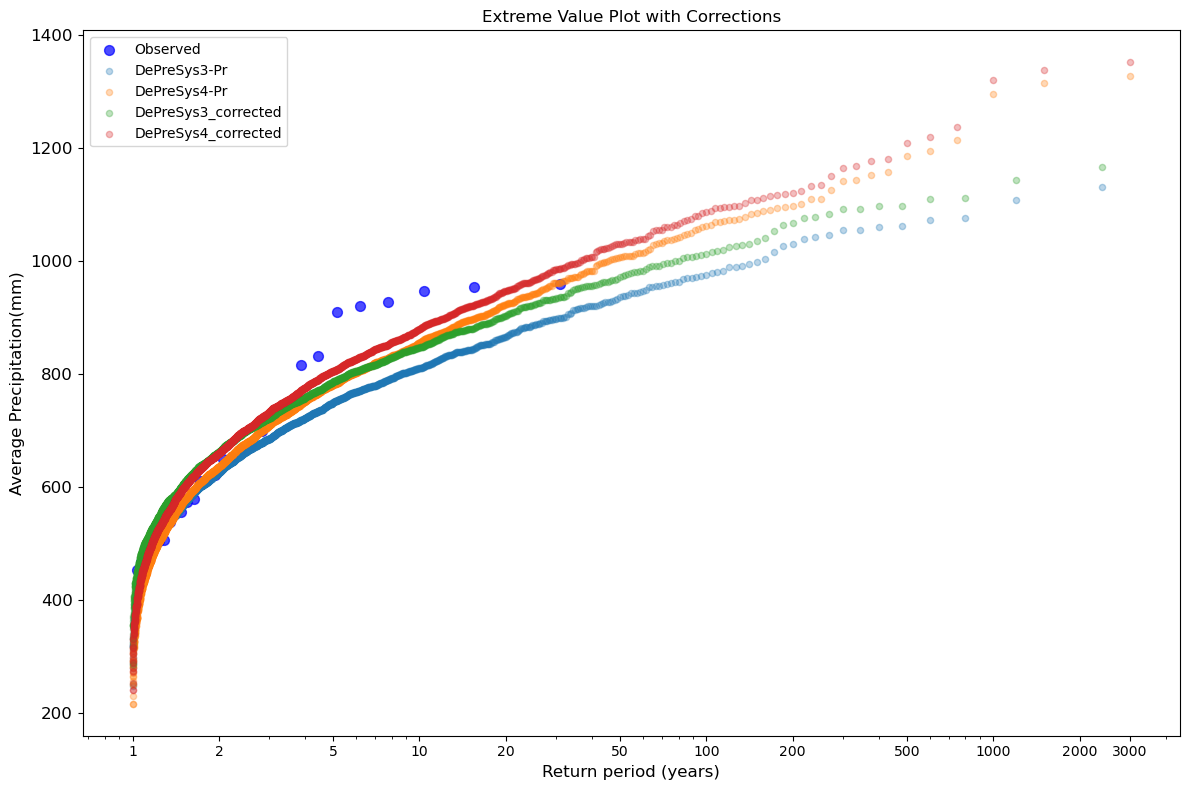

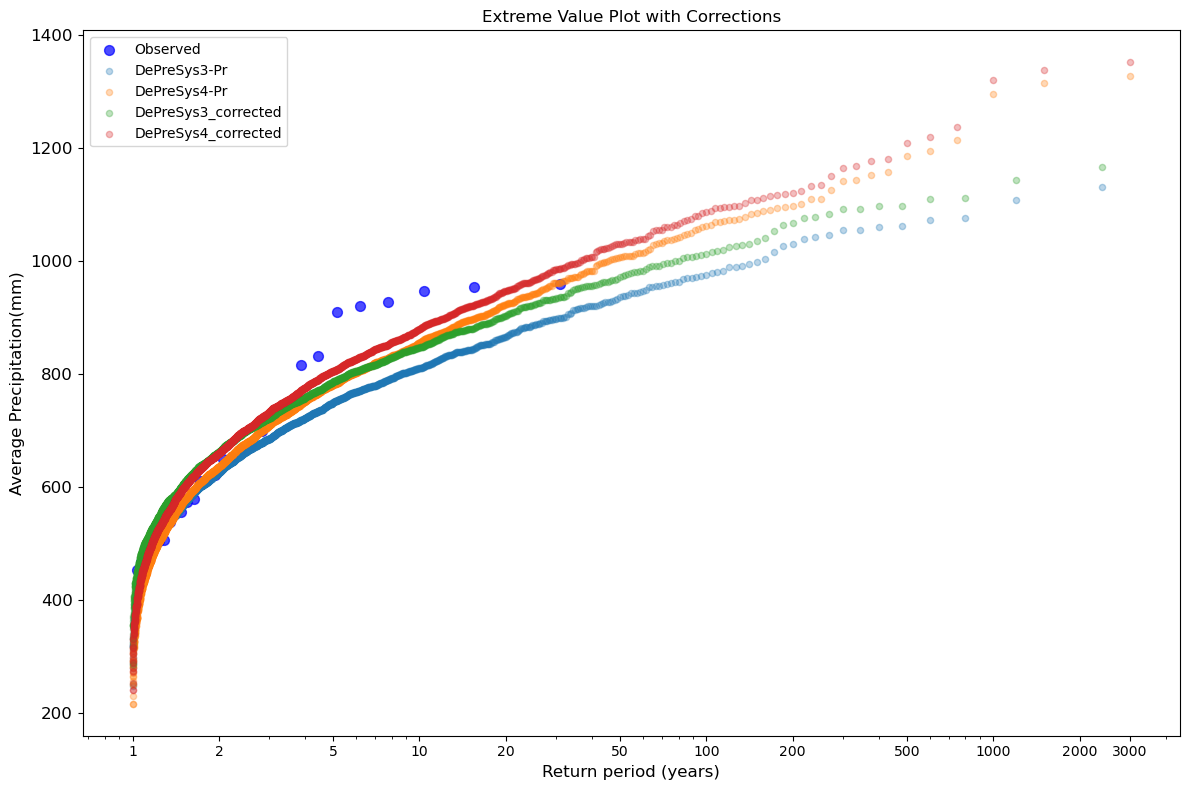

In [35]:
# comparison in return periods
obs_data = obs.data
models_data = [mod3.data,mod4.data,model3_meancor,model4_meancor]
model_names = ['DePreSys3-Pr','DePreSys4-Pr', 'DePreSys3_corrected','DePreSys4_corrected']
plot_return_periods(obs_data, models_data, model_names, n_years=30)


# comparison in return periods
obs_data = obs.data
new_models_data = [new_mod3.data,new_mod4.data,new_model3_meancor,new_model4_meancor]
model_names = ['DePreSys3-Pr','DePreSys4-Pr', 'DePreSys3_corrected','DePreSys4_corrected']
plot_return_periods(obs_data, new_models_data, model_names, n_years=30)

In [ ]:
def calculate_return_periods(data, n_years=30):
    sorted_data = np.sort(data)[::-1]
    ranks = np.arange(1, len(data) + 1)
    return_periods = (n_years * (len(data) / n_years) + 1) / ranks
    return sorted_data, return_periods

def plot_return_periods(obs_data, models_data, model_names, n_years=30,m_ensemble = 100):
    obs_sorted, obs_return_periods = calculate_return_periods(obs_data)
    
    return_periods = np.logspace(0, np.log10(n_years * m_ensemble), 100)
    
    plt.figure(figsize=(12, 8))
    
    # Plot observed data
    plt.scatter(obs_return_periods, obs_sorted, label='Observed', color='blue', alpha=0.7, s=50)
    
    for mod_data, name in zip(models_data, model_names):
        mod_data_flat = mod_data.flatten()      
        # Calculate return periods for the model data
        mod_sorted, mod_return_periods = calculate_return_periods(mod_data_flat)        
        # Plotting model data
        plt.scatter(mod_return_periods, mod_sorted, label=f'{name}', alpha=0.3, s=20)
    
    plt.xscale('log')
    plt.xlabel('Return period (years)', fontsize=12)
    plt.ylabel('Average Values', fontsize=12)
    plt.title('Extreme Value Plot with Corrections', fontsize=12)
    x_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000,3000]
    plt.xticks(x_ticks, x_ticks, fontsize=10)
    plt.legend(fontsize=10)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


# Analysis

In [ ]:
obs = obs.data
mod = model3_meancor

In [ ]:

print("Mod max:", np.max(mod3.data))
print("Mod max:", np.max(model3_meancor))
print("Mod min:", np.min(model3_meancor))
print("Mod mean:", np.mean(model3_meancor))


In [ ]:
obs_max = np.max(obs.data)
obs_min = np.min(obs.data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.hist(model3_meancor.flatten(), bins=50, edgecolor='black')
ax1.axvline(obs_max, color='red', linestyle='--', label='Obs Max')
ax1.axvline(obs_min, color='green', linestyle='--', label='Obs Min')
ax1.set_xlabel('Precipitation (mm)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Corrected DePreSys3 Precipitation Data')
ax1.legend()

ax2.hist(model4_meancor.flatten(), bins=50, edgecolor='black')
ax2.axvline(obs_max, color='red', linestyle='--', label='Obs Max')
ax2.axvline(obs_min, color='green', linestyle='--', label='Obs Min')
ax2.set_xlabel('Precipitation (mm)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Corrected DePreSys4 Precipitation Data')
ax2.legend()

In [ ]:
def calculate_exceedance_probability(data, threshold, precip_increments):
    probs = []
    for precip in precip_increments:
        prob = np.mean(data.flatten() >= (threshold + precip)) * 100
        probs.append(prob)
    return probs

def plot_exceedance_probability(ax, mod, obs, title):
    obs_max = np.max(obs)
    max_increment = obs_max * 0.5
    precip_increments = np.linspace(0, max_increment, 100)
    
    probabilities = calculate_exceedance_probability(mod, obs_max, precip_increments)
    
    n_bootstrap = 1000
    bootstrap_results = []
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(mod.flatten(), size=mod.size, replace=True)
        bootstrap_probs = calculate_exceedance_probability(bootstrap_sample, obs_max, precip_increments)
        bootstrap_results.append(bootstrap_probs)
    
    lower_bound = np.percentile(bootstrap_results, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_results, 97.5, axis=0)
    
    ax.plot(precip_increments, probabilities, color='red', linewidth=2)
    ax.fill_between(precip_increments, lower_bound, upper_bound, color='red', alpha=0.3)
    ax.set_xlabel('Greater than Maximum Observed, degree')
    ax.set_ylabel('Chance of Extremely Low Precipitation')
    ax.set_yscale('log')
    ax.set_ylim(0.25, 10)
    ax.set_xlim(0, max_increment)
    ax.set_yticks([0.25, 1, 2.5, 10])
    ax.set_yticklabels(['0.25%', '1%', '2.5%', '10%'])
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.set_title(title)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=0.5)
    
    return probabilities, precip_increments

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
prob1, precip_increments1 = plot_exceedance_probability(ax1, model3_meancor, obs.data, 'DePreSys3 Precipitation Data\n')
prob2, precip_increments2 = plot_exceedance_probability(ax2, model4_meancor, obs.data, 'DePreSys4 Precipitation Data\n')
plt.tight_layout()
plt.show()

print("Model 1:")
print(f"Chance of exceeding the observed maximum: {prob1[0]:.2f}%")
print(f"Chance of exceeding the observed maximum by 50 mm: {prob1[np.argmin(np.abs(precip_increments1 - 50))]:.2f}%")

print("\nModel 2:")
print(f"Chance of exceeding the observed maximum: {prob2[0]:.2f}%")
print(f"Chance of exceeding the observed maximum by 50 mm: {prob2[np.argmin(np.abs(precip_increments2 - 50))]:.2f}%")

In [ ]:
def calculate_below_minimum_probability(data, threshold, precip_decrements):
    probs = []
    for precip in precip_decrements:
        prob = np.mean(data.flatten() <= (threshold - precip)) * 100
        probs.append(prob)
    return probs

def plot_below_minimum_probability(ax, mod, obs, title):
    obs_min = np.min(obs)
    max_decrement = obs_min * 0.5
    precip_decrements = np.linspace(0, max_decrement, 100)
    
    probabilities = calculate_below_minimum_probability(mod, obs_min, precip_decrements)
    
    n_bootstrap = 1000
    bootstrap_results = []
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(mod.flatten(), size=mod.size, replace=True)
        bootstrap_probs = calculate_below_minimum_probability(bootstrap_sample, obs_min, precip_decrements)
        bootstrap_results.append(bootstrap_probs)
    
    lower_bound = np.percentile(bootstrap_results, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_results, 97.5, axis=0)
    
    ax.plot(precip_decrements, probabilities, color='red', linewidth=2)
    ax.fill_between(precip_decrements, lower_bound, upper_bound, color='red', alpha=0.3)
    ax.set_xlabel('Lower than Minimum Observed, mm')
    ax.set_ylabel('Chance of Extreme Precipitation')
    ax.set_yscale('log')
    ax.set_ylim(0.25, 10)
    ax.set_xlim(0, max_decrement)
    ax.set_yticks([0.25, 1, 2.5, 10])
    ax.set_yticklabels(['0.25%', '1%', '2.5%', '10%'])
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.set_title(title)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=0.5)
    
    return probabilities, precip_decrements

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
prob1, precip_decrements1 = plot_below_minimum_probability(ax1, model3_meancor, obs.data, 'DePreSys3 Precipitation Data\n')
prob2, precip_decrements2 = plot_below_minimum_probability(ax2, model4_meancor, obs.data, 'DePreSys4 Precipitation Data\n')
plt.tight_layout()
plt.show()

print("DePreSys3:")
print(f"Chance of being below the observed minimum: {prob1[0]:.2f}%")
print(f"Chance of being below the observed minimum by 50 mm: {prob1[np.argmin(np.abs(precip_decrements1 - 50))]:.2f}%")
print("\nDePreSys4:")
print(f"Chance of being below the observed minimum: {prob2[0]:.2f}%")
print(f"Chance of being below the observed minimum by 50 mm: {prob2[np.argmin(np.abs(precip_decrements2 - 50))]:.2f}%")